# Part II: Tackling the Eigen cation through exploratory simulations and active learning

In the third part of the tutorial, we will turn our attention to the **Eigen cation**.


<span style="color:red">**Attention!**</span> 

If you are using and **iOS-based system**, you will need to do a little modification for this notebook to run properly.
In the function `_run_single_aims()` in the file `myfunctions.py`, comment the line

`os.system(f"ulimit -s unlimited && {command} ")`

and uncomment the line 

`os.system(f"ulimit -s hard && {command} ")`

in order to correctly set the stack size for the execution of FHI-aims.

In [26]:
from ase.visualize import view
from ase.io import read, write # read and write structures

view(read('../initial-datasets/eigen/eigen.xyz', index=0), viewer='x3d')

Clearly, our current Zundel model already has some degree of knowledge about protonated water clusters: for instance, it knows how an OH bond behaves, it can describe hydrogen bonding and, to some extent, the behavior of proton defects.
However, one might expect that using such a model to run a simulation of a related, but distinct species such as the Eigen cation will not be an overwhelming success straight away. Still, we can rely on active learning to quickly target disagreement outliers and retrain our model iteratively using QbC to gain knowledge across new, unexplored potential energy landscapes.
The only difference now is that our candidate pool is **unlabeled** and we will need to provide the labels (*i.e.*, energies and forces) on the fly during QbC.

# Structure of this tutorial

In the second part of the tutorial, we aim to explore and answer a set of key questions related to **model generalization** and **active learning in molecular simulations**

- **Exploratory simulation of the Eigen cation**:
    - How well does the Zundel-trained committee perform on the Eigen cation without any prior knowledge about it?
    - How can we improve the committee model to better handle the Eigen?
      
- **On-the-fly active learning**:
    - How do we run QbC, when we don't have labelled data?
    - What is the performance of the committee for Eigen after QbC?

#### Import the necessary modules

In [12]:
import os, logging
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms


# import functions to run this tutorial
from myfunctions import train_mace                # train MACE model
from myfunctions import eval_mace                 # evaluate MACE model
from myfunctions import prepare_train_file        # training file preparation for MACE
from myfunctions import forces2disagreement       # calculate disagreement in forces
from myfunctions import extxyz2energy             # extract energy from extxyz file
from myfunctions import extxyz2array              # extract forces from extxyz file
from myfunctions import run_qbc                   # run Query by Committee
from myfunctions import run_single_aims_structure # call FHI-aims
from myfunctions import FHIaimsCalculator

plt.style.use('../files/notebook.mplstyle')                # use notebook style for plots

n_committee = 4                                   # number of committee members

# set random seed for reproducibility
np.random.seed(0) 
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

## 1. Eigen inference

First, we will use the existing model trained only on Zundel structures to perform an **exploratory simulation** of the Eigen.

### Steps to perform inference MD simulation for **eigen** using the committee of machine learning potential

We perform the MD the same way we did for the zundel cation.

**Step 1. Navigate to inference directory**

    `cd ../ipi-examples/eigen-inference/`

**Step 2. Overview of inference directory**

Lets look all the files one by one

2.1 `input.xml` -> input file for i-pi - contains all MD simulation settings, including ensemble, temperature, and reference to the committee models.

2.2 `start.extxyz` -> input structure in extxyz format (here a eigen cation) - input geometry for the simulation.
    
2.3 `run.sh` -> bash script to run MD with committee. (Here please provide the correct path for models)

2.4 `post-process.py` -> removes the lattice for clean visualization 

**Step 3. Run the MD simulation with the committee**

    `./run.sh`


**Step 4. Visualize the trajectory**

    `ase gui eigen-inference.extxyz`


In [13]:
# unzip the checkpoints to load the pretrained models 
! unzip -o ../checkpoints/eigen-inference.zip -d ../ipi-examples

Archive:  ../checkpoints/eigen-inference.zip
  inflating: ../ipi-examples/eigen-inference/eigen-inference.extxyz  
  inflating: ../ipi-examples/eigen-inference/traj.extxyz  
  inflating: ../ipi-examples/eigen-inference/ipi.mean_properties.out  
  inflating: ../ipi-examples/eigen-inference/ipi.mace_force_2.extxyz  
  inflating: ../ipi-examples/eigen-inference/start.extxyz  
  inflating: ../ipi-examples/eigen-inference/ipi.mace_force_0.extxyz  
  inflating: ../ipi-examples/eigen-inference/ipi.mace_properties  
  inflating: ../ipi-examples/eigen-inference/RESTART  
  inflating: ../ipi-examples/eigen-inference/run.sh  
  inflating: ../ipi-examples/eigen-inference/ipi.pos_0.extxyz  
  inflating: ../ipi-examples/eigen-inference/clean.sh  
  inflating: ../ipi-examples/eigen-inference/input.xml  
  inflating: ../ipi-examples/eigen-inference/error.txt  
  inflating: ../ipi-examples/eigen-inference/ipi.mean_force_0.xyz  
  inflating: ../ipi-examples/eigen-inference/ipi.mace_force_3.extxyz  
  in

## Compared to the previous Zundel inference, how does the force disagreement behave during this trajectory?

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

The average disagreement of the Zundel-trained C-NNP on Eigen: 362.108 meV/Å
The average disagreement of the Zundel-trained C-NNP on Zundel: 18.561 meV/Å


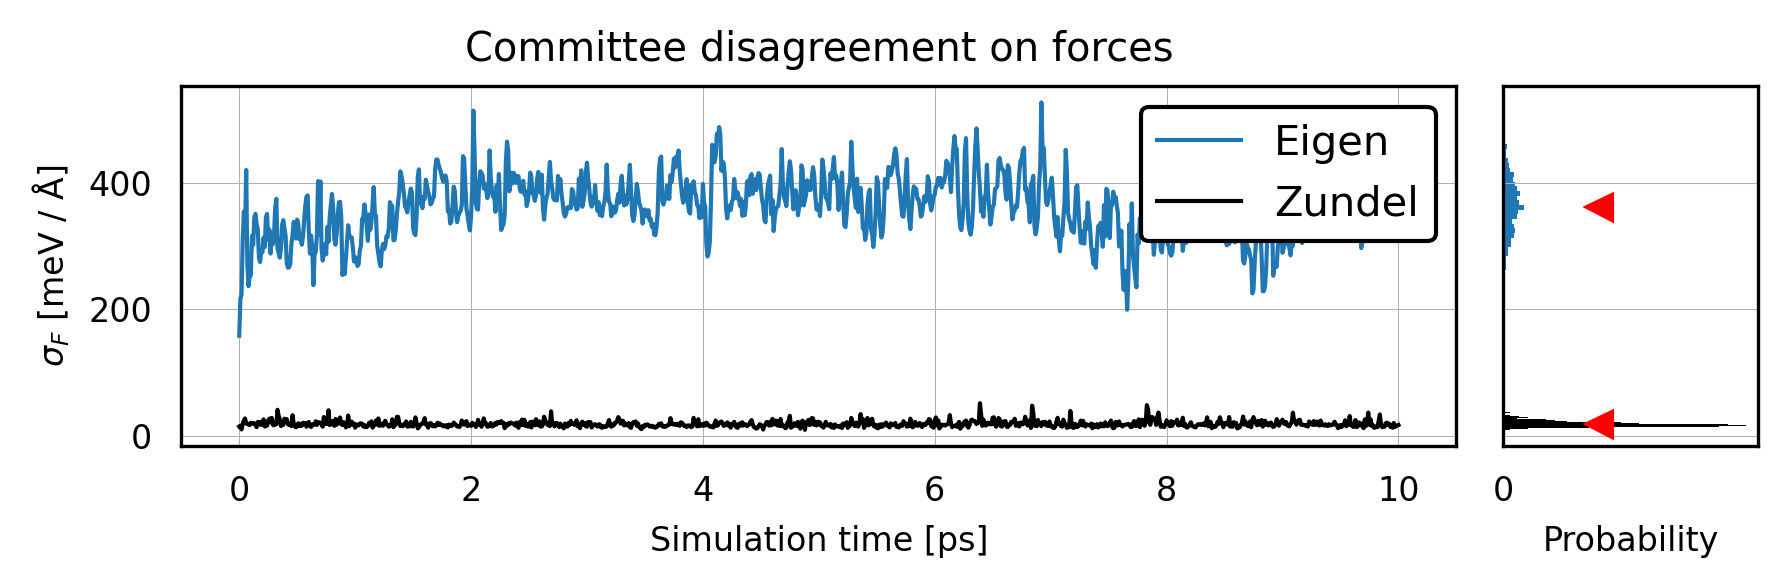

In [14]:
# read the results
forces = np.array([extxyz2array(f'../ipi-examples/eigen-inference/ipi.mace_force_{n:d}.extxyz', 
                                keyword='forces_component_raw') 
                   for n in tqdm(range(n_committee))])
disagreement = 1000 * forces2disagreement(forces) # convert to meV/Å

zundel_forces = np.array([extxyz2array(f'../ipi-examples/zundel-inference/ipi.mace_force_{n:d}.extxyz', 
                               keyword='forces_component_raw') 
                  for n in tqdm(range(n_committee))])
zundel_disagreement = 1000 * forces2disagreement(zundel_forces) # convert to meV/Å


# plot the disagreement
dt = 0.5e-3 # ps
stride = 20 # steps
time = np.arange(0, len(disagreement)) * dt * stride

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))
ax[0].plot(time, disagreement, label='Eigen')
ax[0].plot(time, zundel_disagreement, label='Zundel', color='k')
ax[0].set_ylabel(r'$\sigma_F$ [meV / $\mathrm{\AA}$]')
ax[0].set_xlabel('Simulation time [ps]')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')
ax[0].legend()

ax[1].hist(disagreement, bins=50, orientation='horizontal', density=True)
ax[1].hist(zundel_disagreement, bins=50, orientation='horizontal', density=True, color='k')
ax[1].plot(5e-2, disagreement.mean(), '<', c='r')
ax[1].plot(5e-2, zundel_disagreement.mean(), '<', c='r')
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])

print(f'The average disagreement of the Zundel-trained C-NNP on Eigen: {disagreement.mean():.03f} meV/Å')
print(f'The average disagreement of the Zundel-trained C-NNP on Zundel: {zundel_disagreement.mean():.03f} meV/Å')

plt.tight_layout()
plt.show();

As you can see, the disagreement is **noticeably higher** compared to the Zundel inference using the same model.

## 2. On-the-fly QbC 

In the next step, we take the generated Eigen geometries as a candidate set and run the QbC procedure as before while labeling the data points with energies and forces on the fly.
Explore how an **FHI-aims** calculator is embedded into the QbC functionality.

For the reasons of computational cost of the data labeling using the resources available in this tutorial, we will not run the QbC to complete convergence, but rather as a three-iteration illustration and then rely on a ready-made model trained on enough Eigen structures for the analysis and further inference.

**TODO**: consider how much effort/time this would be to do the QbC on the spot.

<figure style="text-align: center;">
    <img src="images/OTF-QbC_03.png" alt="OTF-QbC diagram" style="width: 100%; max-width: 400px;">
    <figcaption style="font-style: italic; font-size: 90%;">
        Schematic representation of On-the-fly labelling with Query by Committee (QbC) active learning scheme.
    </figcaption>
</figure>

In [15]:
# define tidy folders
md_folder = "md"
init_train_folder = "init-train"
qbc_folder = "qbc-work" # if you modify this, add the new folder to .gitignore
eigen_qbc_folder = "eigen-qbc-work"

In [16]:
# preparing the folder for the QbC results
os.makedirs(eigen_qbc_folder, exist_ok=True)
os.makedirs(f'{eigen_qbc_folder}/config', exist_ok=True)
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

In [17]:
# prepare the config files to train the MACE models
# README: 
# - the files will be saved in the 'init-train/config' folder
# - they are built from a template file: 'train-template.yaml'
# - try to have a look at any of these files to see how the MACE models are trained and constructed

template_file = 'train-template.yaml'
print(f"Using template file '{template_file}' to generate:")

for i in range(n_committee):
    filename = f"{eigen_qbc_folder}/config/config.{i}.yml"
    
    prepare_train_file( template=template_file,            # template file
                        output_path=filename,              # config file to be created
                        replacements={                     # replacements in the template file
                            "NAME" : f"mace.com={i}",    
                            "SEED" : seeds[i],
                            "TRAIN_FOLDER" : eigen_qbc_folder,
                            "RESTART" : True,
                            "TRAIN_FILE":f"{eigen_qbc_folder}/train-iter.extxyz",
                            "DTYPE":"float32"
                        })

    print(f"\t - '{filename}'")

Using template file 'train-template.yaml' to generate:
	 - 'eigen-qbc-work/config/config.0.yml'
	 - 'eigen-qbc-work/config/config.1.yml'
	 - 'eigen-qbc-work/config/config.2.yml'
	 - 'eigen-qbc-work/config/config.3.yml'


In [18]:
# FHI-aims executable
aims_path = os.environ["AIMS"]  # only if you are using our virtual machine
# aims_path = path_to_aims_executable # if you compile aims locally

assert os.path.exists(aims_path), "executable not found"

# ase.Calculator factory
def calculator_factory(n:int,filepath:str):
    os.makedirs('eigen-qbc-work',exist_ok=True)
    os.makedirs('eigen-qbc-work/aims',exist_ok=True)
    directory = f'eigen-qbc-work/aims/run-{n}'
    os.makedirs(directory,exist_ok=True)
    calculator = FHIaimsCalculator(aims_command=f"mpirun -n 8 {aims_path}",
                               control_file="../aims/control.in",
                               directory=directory,
                               output_path="aims.out")
    return calculator

In [19]:
# Attention: this function will not restart from a previously stopped run
run_qbc(
    init_train_folder="qbc-work",
    init_train_file="eigen-initial.extxyz",   # initial training dataset
    fn_candidates=f'../ipi-examples/eigen-inference/traj.extxyz',  # candidate structures
    test_dataset=None,                                             # test set
    n_iter=2,                                                     # number of QbC iterations
    n_add_iter=2,                                                  # number of structures added per iteration
    config='eigen-qbc-work/config',                                # folder with config files
    ofolder='eigen-qbc-work',                                      # folder to save the QBC results                                                  # number of structures to add in each iteration
    recalculate_selected=True,                                     # whether to recalculate the selected structures with DFT (part 2)
    calculator_factory=calculator_factory,
    parallel=False
);

Starting QbC.
Please be sure that the config files use 'eigen-qbc-work/train-iter.extxyz' as training dataset.
Copying checkpoints from 'qbc-work/checkpoints/' to 'eigen-qbc-work/checkpoints/'.
Copying models from 'qbc-work/models/' to 'eigen-qbc-work/models/'.
Number of models in committee: 4
Number of iterations: 2
Number of new candidates added per iteration: 2

Preparing files ...
Candidates pool: '../ipi-examples/eigen-inference/traj.extxyz'
Copying candidates pool from '../ipi-examples/eigen-inference/traj.extxyz' to 'eigen-qbc-work/candidates.start.extxyz'.
No test dataset provided

	--------------------------------------------------------------------
	Starting QbC iteration 1/2

	    Started at: 2025-07-02 14:53:39
	    Evaluating committee disagreement across candidate pool.
	    Evaluation duration: 19.25 seconds

	    Disagreement (pool average): 261.286872 meV/ang
	    Selecting 2 candidates with highest disagreement.

	    Disagreement (selected candidates): 401.699311 meV

Looking at the QbC convergence from the above output, we can see that the model quickly gains knowledge about the new configurations.
We ran this QbC for 10 more iterations adding 10 new Eigen structures at a time and provide the compressed results in the zip file below.

**Try answering the following questions:**

- How many DFT evaluations did we need to achieve this goal?
- How many more would we need if we would start from scratch, *i.e.*, by first performing a first-principles NVT simulation of the Eigen cation?

In [20]:
# unzip the checkpoints to load the pretrained models 
! unzip -o ../checkpoints/eigen-qbc-work.zip 

Archive:  ../checkpoints/eigen-qbc-work.zip
  inflating: eigen-qbc-work/models/mace.com=1.model  
  inflating: eigen-qbc-work/models/mace.com=1_compiled.model  
  inflating: eigen-qbc-work/models/mace.com=3.model  
  inflating: eigen-qbc-work/models/mace.com=0_compiled.model  
  inflating: eigen-qbc-work/models/mace.com=2.model  
  inflating: eigen-qbc-work/models/mace.com=0.model  
  inflating: eigen-qbc-work/models/mace.com=2_compiled.model  
  inflating: eigen-qbc-work/models/mace.com=3_compiled.model  
  inflating: eigen-qbc-work/eval/train_00.extxyz  
  inflating: eigen-qbc-work/eval/train_02.extxyz  
  inflating: eigen-qbc-work/eval/train_01.extxyz  
  inflating: eigen-qbc-work/eval/train_03.extxyz  
  inflating: eigen-qbc-work/eval/.ipynb_checkpoints/train_00-checkpoint.extxyz  
  inflating: eigen-qbc-work/disagreement.txt  
  inflating: eigen-qbc-work/train-final.extxyz  


## 3. Evaluation of the refined model

After the QbC has finished, let us re-evaluate the initial Eigen trajectory with the improved model.\
**How has the disagreement changed**?

In [21]:
# Predict with all MACE committee members
for n in tqdm(range(n_committee)):
    eval_mace(f'{eigen_qbc_folder}/models/mace.com={n:d}_compiled.model',
              '../ipi-examples/eigen-inference/traj.extxyz',
              f'{eigen_qbc_folder}/eval/train_{n:02d}.extxyz')  

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
forces = np.array([extxyz2array(f'{eigen_qbc_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_forces') 
                           for n in tqdm(range(n_committee))])
disagreement_after_qbc = forces2disagreement(forces) * 1000

  0%|          | 0/4 [00:00<?, ?it/s]

The average disagreement before seeing Eigen structures: 362.108 meV/Å.
The average disagreement after seeing 100 QbC Eigen structures: 29.892 meV/Å.


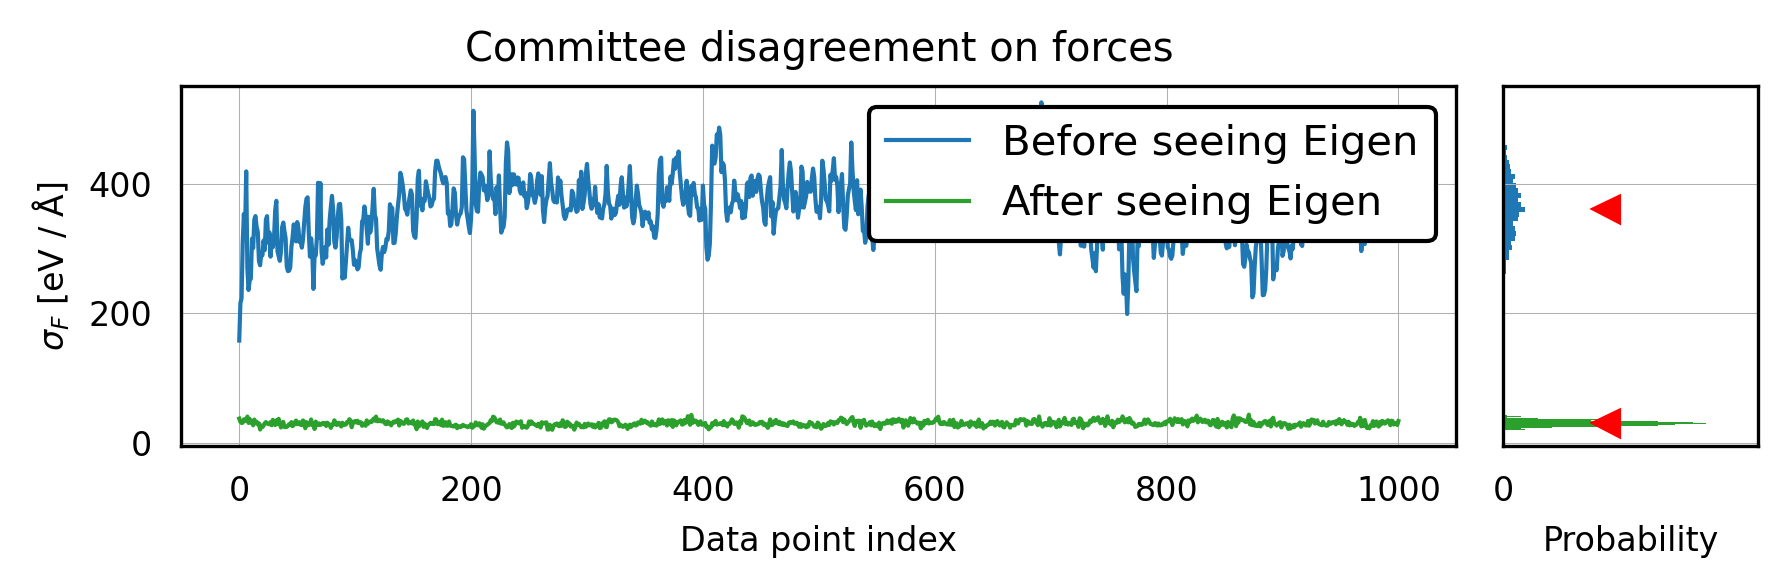

In [25]:
dt = 0.5e-3 # ps
stride = 20 # steps
time = np.arange(0, len(disagreement)) * dt * stride

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))
ax[0].plot(disagreement, label='Before seeing Eigen')
ax[0].plot(disagreement_after_qbc, label='After seeing Eigen', color='tab:green')
ax[0].set_ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
ax[0].set_xlabel('Data point index')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')
ax[0].legend()

ax[1].hist(disagreement, bins=50, orientation='horizontal', density=True)
ax[1].plot(5e-2, disagreement.mean(), '<', c='r')
ax[1].hist(disagreement_after_qbc, bins=50, orientation='horizontal', density=True, color='tab:green')
ax[1].plot(5e-2, disagreement_after_qbc.mean(), '<', c='r')
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])

print(f'The average disagreement before seeing Eigen structures: {disagreement.mean():.03f} meV/Å.')
print(f'The average disagreement after seeing 100 QbC Eigen structures: {disagreement_after_qbc.mean():.03f} meV/Å.')

plt.tight_layout()
plt.show();